<a href="https://colab.research.google.com/github/AkshitTayade/Microscopic-Imaging---Internship/blob/main/BreastCancer_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Breast Cancer Prediction Using Custom Hybrid Architecture
> This notebook was created for breast cancer prediction from histology slides of magnification 200x


`Breast Cancer Prediction from Histology Slides`
<br>
`BreakHis`
<br>
`Subset Used: 200x`

[Link to Download the dataset](https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/)

**Date Created**: February 19, 2022


**Author**:
 Anish Pawar, Sagar Kamat

[[Course Repository](https://github.com/AkshitTayade/Microscopic-Imaging---Internship)]

# Imports

In [12]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten
import json

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import pickle
import cv2

from google.colab import drive
from google.colab import files
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Helper Functions

In [13]:
class FeatureExtractor:
    def __init__(self,image) -> None:
        self.base_model = tf.keras.applications.VGG19(input_shape=(150,150,3),
                                               include_top=False,
                                               weights='imagenet')
        self.image = image       
        self.extractedFeatures = []    
        self.featureCreator()


    def featureCreator(self):            
        slicedImages = self.slicer(self.image)

        currentExtractedFeatures = []

        for image in slicedImages:
            currentExtractedFeatures.append(self.featureExtractor(image).numpy())

        self.extractedFeatures.append(currentExtractedFeatures)



    def slicer(self,img):
        # img = plt.imread(imagePath)
        h, w = img.shape[:2]
        ls = []
        for i in range(3):
            roi3 = img[:, int(w*i/3): int(w/3) + int(w*i/3)]
            # plt.imshow(roi)
            for j in range(3):
                roi9 = roi3[int(h*j/3): int(h/3) + int(h*j/3), :]
                ls.append(roi9)
        return ls                    
                                                       
    def preProcessor(self,img):
        img = cv2.resize(img,(150,150))
        imgx = np.expand_dims(img, axis=0)
        return imgx                                        
    
    def featureExtractor(self,image):
        feature = self.base_model(self.preProcessor(image))
        flattened = Flatten()(feature)
        # print(feature.shape,flattened.shape)
        return flattened

In [14]:
def featureScaler(feature):

    maxVal = max(feature)
    minVal = min(feature)

    dezmin = 0
    dezmax = 1

    scaledFeatures =  []
    for i in feature:
        scaled = (    (   (i - minVal)/(maxVal-minVal)  ) /   (dezmax-dezmin)    ) + dezmin
        scaledFeatures.append(scaled)

    return np.array(scaledFeatures)

In [15]:
def SVMDataPreProc(subset):
    # subset
    slicedDataset = []
    for j in range(9):
            temp = []
            for i in subset:
                temp.append(featureScaler(i[j][0]))

            slicedDataset.append(temp)
    return slicedDataset

In [16]:
class MultiSVMPredictor:
    def __init__(self,X,classifiers) -> None:
        self.X = X
        # self.y = y
        self.classifiers = classifiers
        self.preds = []

        self.prediction()
    
    def prediction(self):
        for i in range(9):
            self.preds.append(self.classifiers[i].predict(self.X[i]))

# Predictor

In [17]:
def imagePredictor(imagePath,dirbase):
  preds = []
  # imagePath = imgdir
  img = plt.imread(imagePath)
  CNNExtractedFeatures = FeatureExtractor(img)
  SVMData = SVMDataPreProc(CNNExtractedFeatures.extractedFeatures)


  svms = []
  for i in range(1,10):
      with open(f'{dirbase}/SVM-{i}.pkl', 'rb') as fid:
          svms.append(pickle.load(fid))


  SVMOutput = MultiSVMPredictor(SVMData,svms)


  aval1 = SVMOutput.preds[0]
  aval2 = SVMOutput.preds[1]
  aval3 = SVMOutput.preds[2]
  aval4 = SVMOutput.preds[3]
  aval5 = SVMOutput.preds[4]
  aval6 = SVMOutput.preds[5]
  aval7 = SVMOutput.preds[6]
  aval8 = SVMOutput.preds[7]
  aval9 = SVMOutput.preds[8]


  valEnsemblePreds = []
  for i in range(len(aval1)):
      valEnsemblePreds.append(np.array([aval1[i],aval2[i],aval3[i],aval4[i],aval5[i],aval6[i],aval7[i],aval8[i],aval9[i]]))


  with open(f'{dirbase}/Decider-SVM.pkl', 'rb') as fid:
      DeciderSVM = pickle.load(fid)



  y_preds = DeciderSVM.predict(valEnsemblePreds)

  preds.append(y_preds)

  plt.imshow(img)

  if y_preds == 0:
      print('Malignant')
  else:
      print('Benign')

# Run This

Saving SOB_M_DC-14-2523-200-031.png to SOB_M_DC-14-2523-200-031.png
Malignant


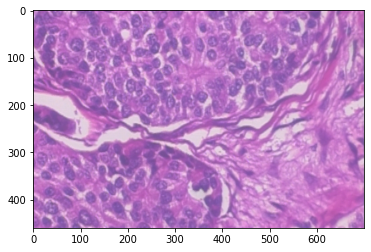

In [19]:
uploaded = files.upload()
imgdir = f'/content/{list(uploaded.keys())[0]}'

dirbase = '/content/drive/MyDrive/Ninad_Sir_Internship_KJSCE/Microscopic_Images_Internship/Final_Submission/SVM_Models'


imagePredictor(imgdir,dirbase)